## Sign Language Detection System Using YOLOv5 Algorithm to Promote Communication Equality for People with Disabilities in Support of SDGS

Yopi Julia Nurriski

# 1. Instalasi dan Import Package:
Pada blok ini, kita melakukan instalasi dan impor paket-paket yang diperlukan untuk pengembangan model, termasuk super-gradients, imutils, roboflow, dan lainnya.

In [ ]:
%%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-12-09 13:46:36] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-12-09 13:46:36] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-12-09 13:46:36] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-12-09 13:46:48] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-12-09 13:46:48] WARNING - export.py - Failed to import pytorch_quantization
[2023-12-09 13:46:48] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-12-09 13:46:48] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-12-09 13:46:48] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-12-09 13:46:48] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-12-09 13:46:48] WARNING - env_sanity_check.py - 

In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

# 2. Inisialisasi Trainer dan Roboflow:
Pada blok ini, kita menginisialisasi objek Trainer dari super_gradients dengan menentukan nama eksperimen dan direktori checkpoint. Selain itu, kita menggunakan Roboflow untuk mengunduh dataset dari proyek yang ditentukan.

In [ ]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='sign_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="GuRIbgNtA2NPlqFYFxAP")
project = rf.workspace("capstone-projet").project("sign-language-bisindo-qdpec")
dataset = project.version(5).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to sign-language-bisindo-5 in yolov5pytorch::   0%|          | 0/11048 [00:00<?, ?it/s]

Extracting Dataset Version Zip to sign-language-bisindo-5 in yolov5pytorch:: 100%|██████████| 11048/11048 [00:01<00:00, 7987.11it/s] 


# 3. Pengaturan Parameter Dataset:
Pada blok ini, kita menetapkan parameter untuk dataset, termasuk direktori data, direktori gambar dan label untuk setiap tahap (latihan, validasi, uji), dan daftar kelas yang diinginkan.

In [ ]:
dataset_params = {
    'data_dir':'/content/sign-language-bisindo-5',
    'train_images_dir':'/content/sign-language-bisindo-5/train/images',
    'train_labels_dir':'/content/sign-language-bisindo-5/train/labels',
    'val_images_dir':'/content/sign-language-bisindo-5/valid/images',
    'val_labels_dir':'/content/sign-language-bisindo-5/valid/labels',
    'test_images_dir':'/content/sign-language-bisindo-5/test/images',
    'test_labels_dir':'/content/sign-language-bisindo-5/test/labels',
    'classes': ['A', 'AKU', 'APA', 'AYAH', 'B', 'BAIK', 'BANTU', 'BERMAIN', 'C', 'D', 'DIA', 'E', 'F', 'G','H', 'I', 'J', 'JANGAN', 'K', 'KAKAK', 'KAMU', 'KAPAN', 'KEREN', 'KERJA', 'L','M', 'MAAF', 'MARAH', 'MINUM', 'N','O', 'P', 'Q', 'R', 'RUMAH', 'S', 'SABAR', 'SEDIH', 'SENANG', 'SUKA', 'T', 'U',  'V', 'W', 'X', 'Y', 'Z', ]
}

# 4. Pembentukan Dataloader:
Pada blok ini, kita membuat dataloader untuk latihan, validasi, dan pengujian menggunakan format YOLO pada dataset COCO. Kita juga membersihkan output agar lebih rapi.

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

# 5. Transformasi Data:
Pada blok ini, kita dapat melihat transformasi data yang diterapkan pada dataset latihan dan memvisualisasikan contoh data setelah transformasi.

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

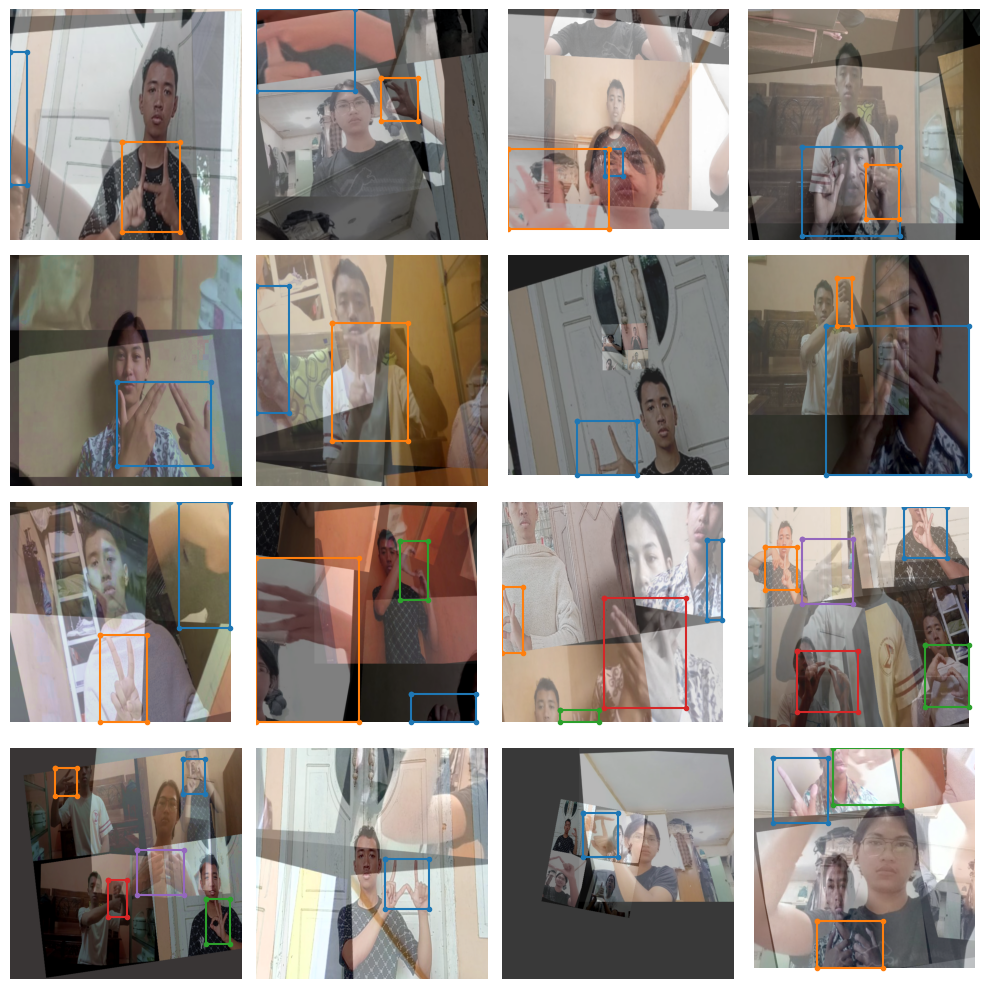

In [ ]:
train_data.dataset.plot()

# 6. Inisialisasi Model YOLO-NAS-S:
Pada blok ini, kita inisialisasi model YOLO-NAS-S dari super_gradients dengan menentukan jumlah kelas dan menggunakan bobot pra-latih dari dataset COCO.



In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-12-09 13:48:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:00<00:00, 226MB/s]
[2023-12-09 13:48:13] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


7. Pengaturan Parameter Pelatihan:
Pada blok ini, kita menetapkan parameter untuk pelatihan, termasuk mode diam, jumlah epoch maksimum, fungsi kerugian, optimizer (Adam), dan metrik evaluasi (mAP@0.50).

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 25,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
!gdown "https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1bLlfh9gr6JxE9Wacw4xgv5FNijA7j9GZ&confirm=t
To: /content/demonew1.mp4
100% 1.26M/1.26M [00:00<00:00, 9.96MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1kju9OOo05c5XTfrKuLvsZcxu_NPloQk_&confirm=t"

# 8. Pelatihan Model:
Pada blok ini, kita melatih model menggunakan Trainer dengan dataloader latihan dan validasi.

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-12-09 13:48:40] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231209_134840_845388`
[2023-12-09 13:48:40] INFO - sg_trainer.py - Checkpoints directory: checkpoints2/sign_yolonas_run2/RUN_20231209_134840_845388
[2023-12-09 13:48:40] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to checkpoints2/sign_yolonas_run2/RUN_20231209_134840_845388/console_Dec09_13_48_40.txt


[2023-12-09 13:48:46] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            5010       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         313        (len(train_loader))
    - Gradient updates per epoch:   313        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.04M parameters, 19.04M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.04M parameters). LR: 0.0005 (19.04M parameters) WD: 0.0, (42.27K parameters), WD: 0.0001, (19.00M parameters)

[2023-12-09 13:54:47] INFO - base_sg_logger.py - Checkpoint saved i

# 9. Pemilihan Model Terbaik:
Pada blok ini, kita memilih model terbaik berdasarkan kinerja pada validasi.

In [ ]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints2/sign_yolonas_run2/RUN_20231209_134840_845388/ckpt_best.pth")

# 10. Pengujian Model Terbaik:
Pada blok ini, kita menguji model terbaik menggunakan dataloader uji dan metrik evaluasi deteksi objek.

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 14/14 [00:06<00:00,  2.08it/s]


{'PPYoloELoss/loss_cls': 0.7041939,
 'PPYoloELoss/loss_iou': 0.37712878,
 'PPYoloELoss/loss_dfl': 0.51016027,
 'PPYoloELoss/loss': 1.5914824,
 'Precision@0.50': 0.17831620573997498,
 'Recall@0.50': 0.9968944191932678,
 'mAP@0.50': 0.9726730585098267,
 'F1@0.50': 0.2907600402832031}

Nilia 'Recall@0.50': 0.9968944191932678
Nilai 'mAP@0.50': 0.9726730585098267